In [1]:
import scanpy as sc
import custom_tools
import os
import numpy as np
import anndata as ad
import decoupler as dc
import seaborn as sns
from dataset import TissueDataset

Global seed set to 42


In [7]:
# Read json file
exp_name = "METABRIC_PNAConv_NegativeLogLikelihood_fixed_dataset_04-01-2024"
job_id = "dGMbZiU1cccDyS_Udt2xGg"
device =  custom_tools.get_device()
args  = custom_tools.load_json(f"../models/{exp_name}/{job_id}.json")
# args["num_node_features"] = 33
deg = None
if "PNA" in exp_name:
    deg = custom_tools.load_pickle(f"../models/{exp_name}/{job_id}_deg.pckl")
model = custom_tools.load_model(f"{job_id}_SD", path = f"../models/{exp_name}", model_type = "SD", args = args, deg=deg, device=device)


dataset = TissueDataset(os.path.join("../data/METABRIC", "month"),  "month")

Global seed set to 42


CPU is available on this device!
Target prediction: OSmonth


In [8]:
dataset[0]

Data(x=[347, 39], edge_index=[2, 1962], y=[1], pos=[347, 2], osmonth=[1], clinical_type='HR+HER2+', treatment='YES', disease_stage=[1], tumor_grade=[1], img_id='437ll', p_id='MB-0291', age=[1], disease_status='Died of Disease', dfs_month=[1], is_censored=[1])

In [9]:
import embeddings
emd, related_data = embeddings.get_intermediate_embeddings_for_dataset(model, dataset, batch_size=1)

In [10]:
related_data

[DataBatch(x=[347, 39], edge_index=[2, 1962], y=[1], pos=[347, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1], batch=[347], ptr=[2]),
 DataBatch(x=[339, 39], edge_index=[2, 1924], y=[1], pos=[339, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1], batch=[339], ptr=[2]),
 DataBatch(x=[405, 39], edge_index=[2, 2308], y=[1], pos=[405, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1], batch=[405], ptr=[2]),
 DataBatch(x=[331, 39], edge_index=[2, 1864], y=[1], pos=[331, 2], osmonth=[1], clinical_type=[1], treatment=[1], disease_stage=[1], tumor_grade=[1], img_id=[1], p_id=[1], age=[1], disease_status=[1], dfs_month=[1], is_censored=[1],

In [11]:
embedding_arr = np.array(emd[0])
embedding_arr.shape
pid_list, img_id_list, osmonth_lst,  clinical_type_lst, tumor_grade_lst= [], [], [], [], []
for data in related_data:
    pid_list.append(str(data.p_id[0]))
    osmonth_lst.append(data.osmonth.item())
    img_id_list.append(data.img_id[0])
    clinical_type_lst.append(data.clinical_type[0])
    tumor_grade_lst.append(str(data.tumor_grade.item()))

embedding_arr.shape
embedding_arr.shape[1]

256

In [12]:
adata = ad.AnnData(embedding_arr)
adata.var_names = [f"emb_{i}" for i in range(embedding_arr.shape[1])]
adata.obs_names = img_id_list
adata.obs["img_id"] = img_id_list
adata.obs["osmonth"] = osmonth_lst
adata.obs["p_id"] = pid_list
adata.obs["clinical_type"] = clinical_type_lst
adata.obs["tumor_grade"] = tumor_grade_lst

adata.obs

,img_id,osmonth,p_id,clinical_type,tumor_grade
437ll,437ll,39.200000,MB-0291,HR+HER2+,3.0
246ur,246ur,111.866667,MB-0227,HR+HER2-,2.0
160lr,160lr,48.600000,MB-0542,HR+HER2-,3.0
553ur,553ur,109.033333,MB-0184,HR+HER2-,2.0
261,261,26.266667,MB-0401,TripleNeg,3.0
...,...,...,...,...,...
68,68,144.633333,MB-0192,HR+HER2-,1.0
387ll,387ll,149.766667,MB-0243,HR+HER2-,2.0
310lr,310lr,111.100000,MB-0474,HR+HER2-,3.0
97ll,97ll,95.866667,MB-0119,HR+HER2-,2.0


In [13]:
sc.tl.pca(adata, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


In [14]:
sc.tl.leiden(adata, key_added = "leiden")

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


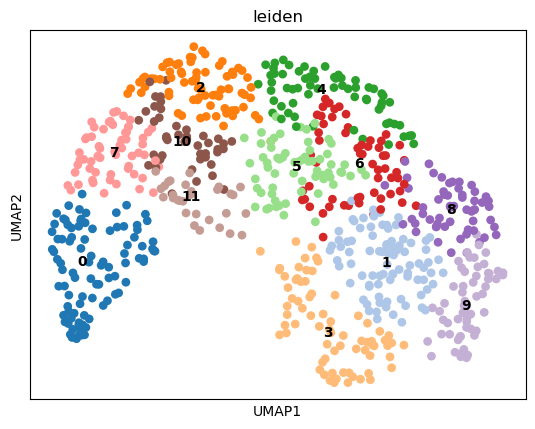

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


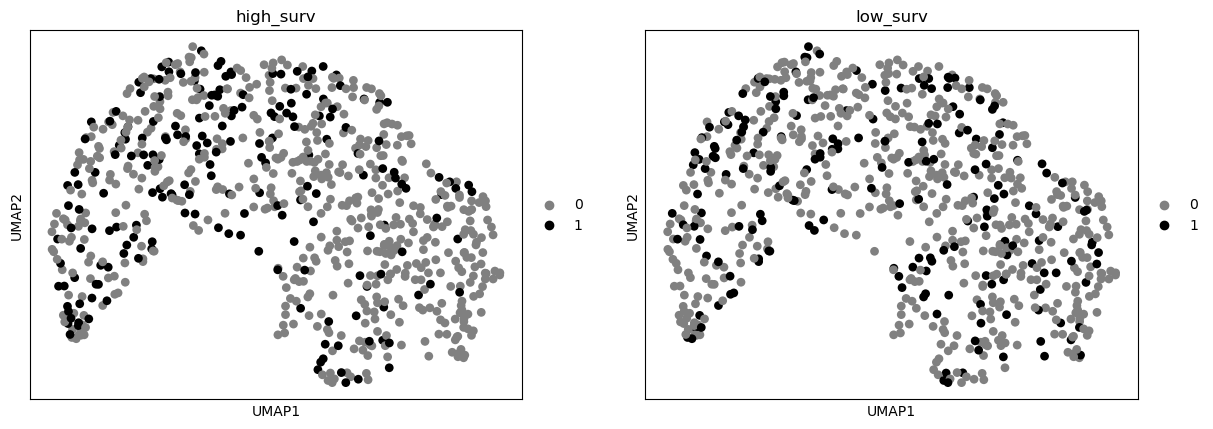

<Axes: xlabel='leiden', ylabel='osmonth'>

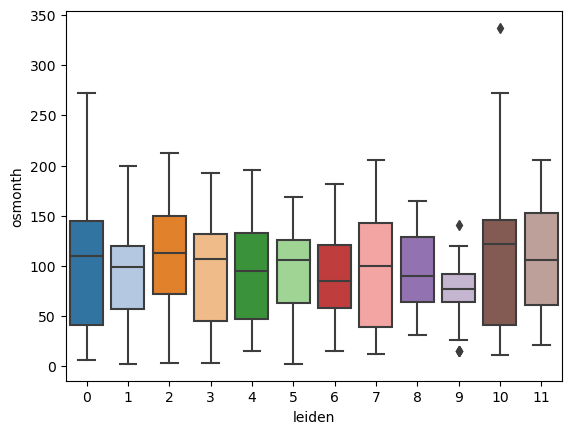

In [15]:
# sc.pl.umap(adata, color=["osmonth", "le"iden"])
upper_quartile = int(np.quantile(adata.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata.obs["osmonth"], 0.25))


adata.obs["high_surv"]="0"
adata.obs["low_surv"]="0"

adata.obs.loc[adata.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata.obs.loc[adata.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"

cmap = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata.obs["leiden"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata, color=["leiden"], palette=color_dict, legend_loc = 'on data')
sc.pl.umap(adata, color=["high_surv", "low_surv"], palette=["grey", "black"])
sns.boxplot(data=adata.obs, x="leiden", y="osmonth", palette= color_dict)

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


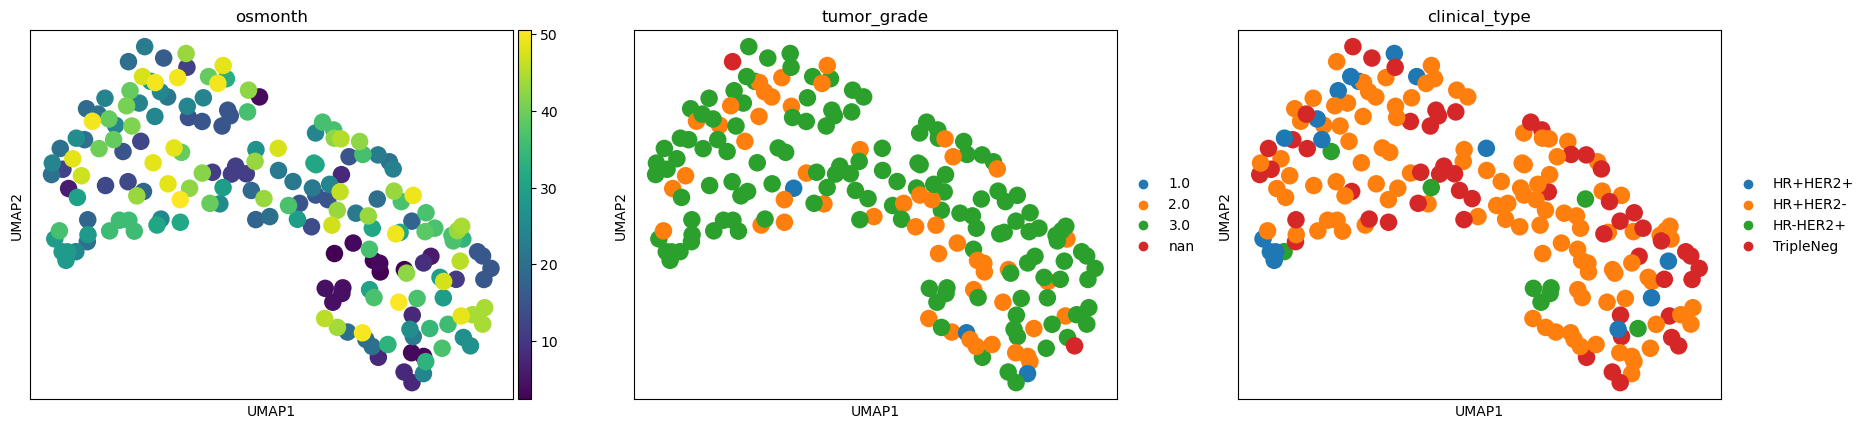

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


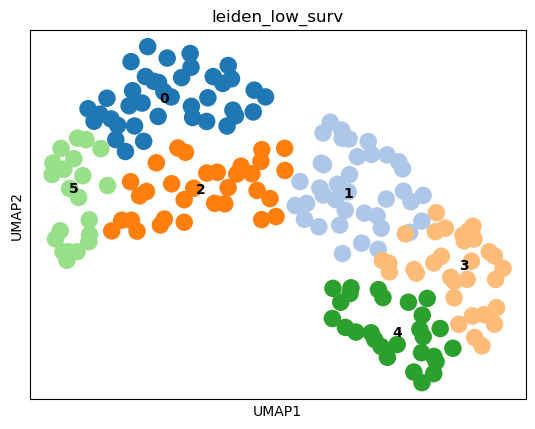

<Axes: xlabel='leiden_low_surv', ylabel='osmonth'>

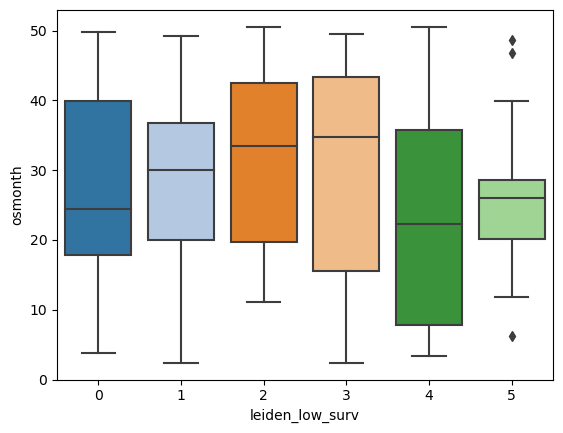

In [20]:
lower_quartile = int(np.quantile(adata.obs["osmonth"], 0.25))
adata_lower = adata[adata.obs["osmonth"]<lower_quartile,:].copy()

sc.tl.pca(adata_lower, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_lower)
sc.tl.umap(adata_lower)

sc.tl.leiden(adata_lower, resolution=1.0, key_added = "leiden_low_surv")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_lower.obs["leiden_low_surv"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_lower, color=["osmonth", "tumor_grade", "clinical_type"])
sc.pl.umap(adata_lower, color="leiden_low_surv", palette=color_dict, legend_loc = 'on data')
sns.boxplot(data=adata_lower.obs, x="leiden_low_surv", y="osmonth", palette= color_dict)
# sc.pl.violin(adata_lower, 'osmonth', groupby='leiden', palette=color_dict)

In [17]:
adata_clinical_subtype = adata[adata.obs["clinical_type"]=="HR+HER2-",:].copy()

"""
upper_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.75))
lower_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.25))


adata_clinical_subtype.obs["high_surv"]="0"
adata_clinical_subtype.obs["low_surv"]="0"

adata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"
adata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"
"""


'\nupper_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.75))\nlower_quartile = int(np.quantile(adata_clinical_subtype.obs["osmonth"], 0.25))\n\n\nadata_clinical_subtype.obs["high_surv"]="0"\nadata_clinical_subtype.obs["low_surv"]="0"\n\nadata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]>upper_quartile, "high_surv" ] = "1"\nadata_clinical_subtype.obs.loc[adata_clinical_subtype.obs["osmonth"]<lower_quartile, "low_surv" ] = "1"\n'

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


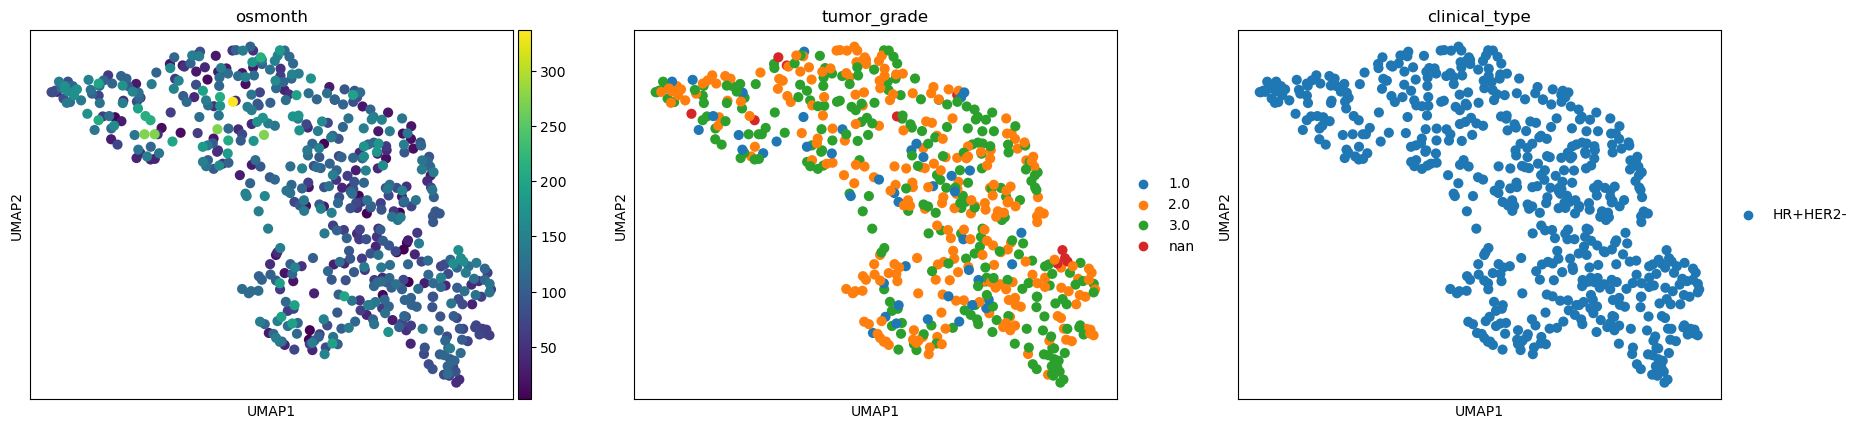

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


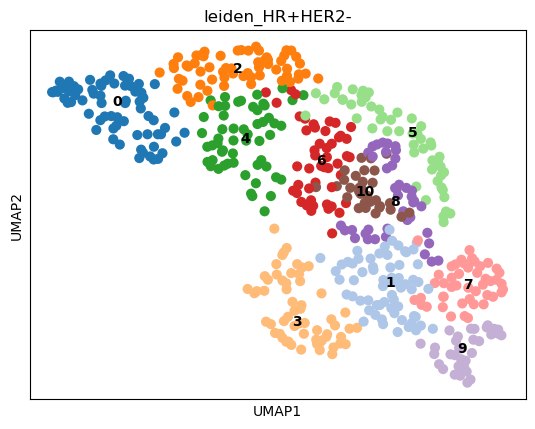

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


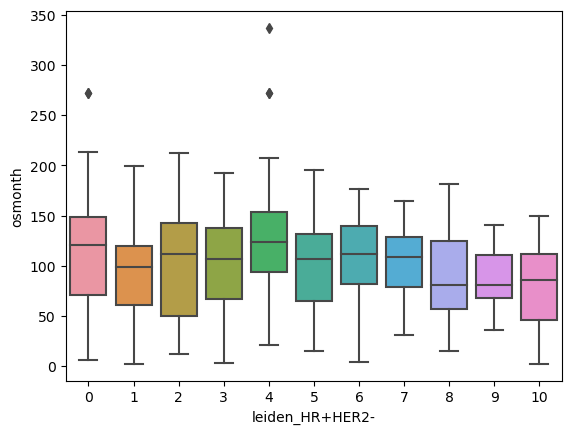

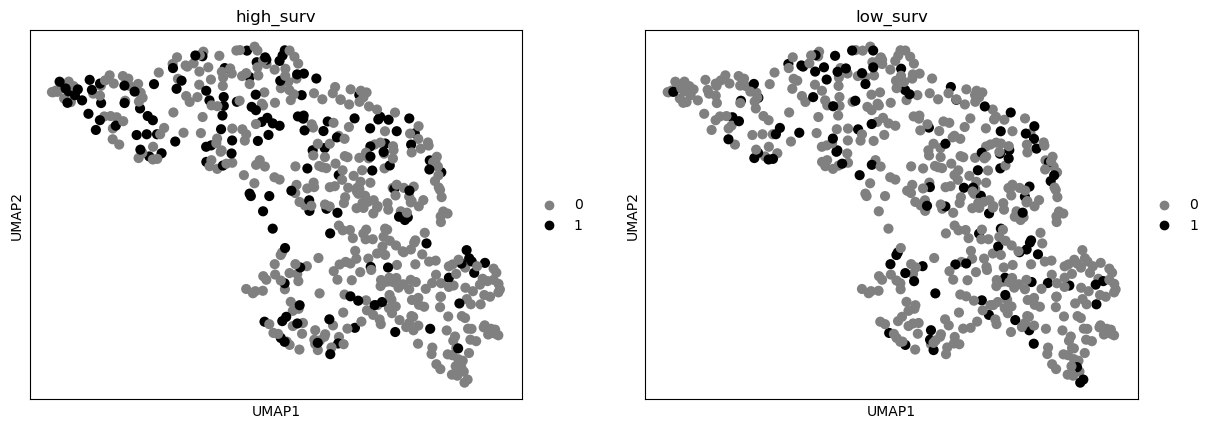

In [21]:
sc.tl.pca(adata_clinical_subtype, svd_solver='arpack', random_state=0)
sc.pp.neighbors(adata_clinical_subtype)
sc.tl.umap(adata_clinical_subtype)

sc.tl.leiden(adata_clinical_subtype, resolution=1.0, key_added = "leiden_HR+HER2-")

color_dict = dict()
map = sns.palettes.get_colormap("tab20")
color_dict = dict()

for ind, clust_index in enumerate(adata_clinical_subtype.obs["leiden_HR+HER2-"].cat.categories):
    color_dict[clust_index] = cmap.colors[ind]

sc.pl.umap(adata_clinical_subtype, color=["osmonth", "tumor_grade", "clinical_type"])
sc.pl.umap(adata_clinical_subtype, color="leiden_HR+HER2-", palette=color_dict, legend_loc = 'on data')
sns.boxplot(data=adata_clinical_subtype.obs, x="leiden_HR+HER2-", y="osmonth")
sc.pl.umap(adata_clinical_subtype, color=["high_surv", "low_surv"])

In [19]:
adata_exp = sc.read_h5ad("/net/data.isilon/ag-saez/bq_arifaioglu/home/Projects/GNNClinicalOutcomePrediction/data/out_data/adatafiles/METABRIC_concatenated_explanations.h5ad")
adata_exp.obs_names_make_unique()

KeyboardInterrupt: 

In [138]:
adata_exp.obs

,clinical_type,img_id,p_id,tumor_grade,osmonth,importance,importance_hard
0,HR+HER2+,72lr,280-basel,tensor([3]),166.0,0.076901,False
1,HR+HER2+,72lr,280-basel,tensor([3]),166.0,0.048704,False
2,HR+HER2+,72lr,280-basel,tensor([3]),166.0,0.091498,False
3,HR+HER2+,72lr,280-basel,tensor([3]),166.0,0.322848,True
4,HR+HER2+,72lr,280-basel,tensor([3]),166.0,0.386858,True
...,...,...,...,...,...,...,...
664-647,TripleNeg,232ul,89-basel,tensor([3]),95.0,0.256618,False
665-644,TripleNeg,232ul,89-basel,tensor([3]),95.0,0.129562,False
666-643,TripleNeg,232ul,89-basel,tensor([3]),95.0,0.081532,False
667-643,TripleNeg,232ul,89-basel,tensor([3]),95.0,0.016499,False


In [143]:
pdata = dc.get_pseudobulk(
    adata_exp,
    sample_col='img_id',
    groups_col='importance_hard',
    mode='mean',
    min_cells=0,
    min_counts=0
)

pdata

/net/data.isilon/ag-saez/bq_arifaioglu/miniconda3/envs/py_gem/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 1462 × 33
    obs: 'clinical_type', 'img_id', 'p_id', 'tumor_grade', 'osmonth', 'importance_hard', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

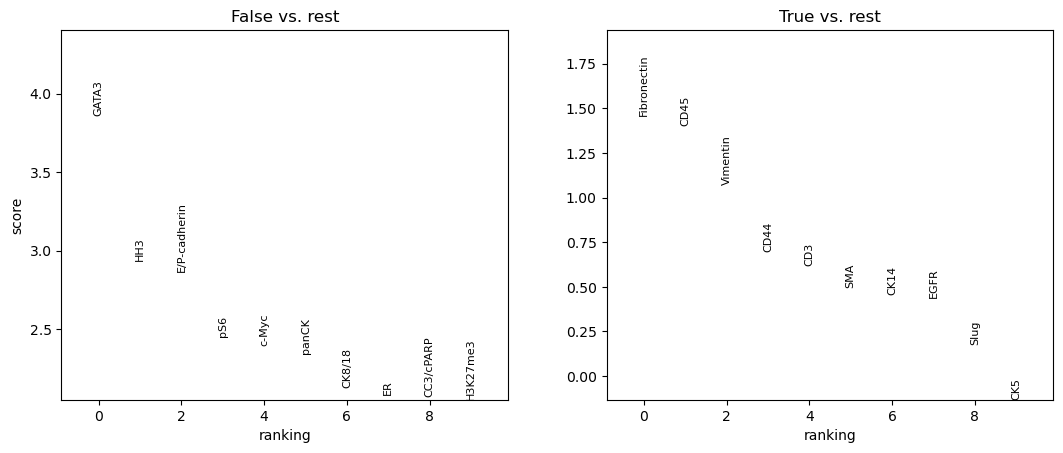

In [157]:
sc.tl.rank_genes_groups(pdata, 'importance_hard', method='t-test')
sc.pl.rank_genes_groups(pdata, n_genes=10, sharey=False)

In [152]:
print(adata_exp.X.shape)
print(adata_exp.X[~np.isnan(adata_exp.X).any(axis=1)].shape)

print(pdata.X.shape)
print(pdata.X[~np.isnan(pdata.X).any(axis=1)].shape)

(759541, 33)
(759541, 33)
(1462, 33)
(1462, 33)
